In [41]:
import sys
import numpy as np
from scipy.stats import multivariate_normal
import signal
import torch
import re
import pandas as pd
from torch.distributions.multivariate_normal import MultivariateNormal
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../SOGA-main/src')
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

torch.set_default_dtype(torch.float64)
from fitness.soga_fitness_trueskills import *
from algorithm.parameters import params
import utils

In [33]:
model_name = 'if_sketch2'

In [34]:

avg_fitness_5000, textbf = utils.read_fitness_and_program(model_name)
print('Average fitness of best found program on 5000 data: ', np.nanmean(avg_fitness_5000))
best_program_file = path.join(file_path, str(runs[np.nanargmax(avg_fitness_5000)]), "best.txt")
file = open(best_program_file)
text_bf = ''
flag = False
for line in file.readlines():
    if 'Phenotype' in line:
        flag = True
        continue
    if 'Genotype' in line:
        flag = False
        break
    if flag:
        text_bf += line + ' '

fitness_bf = likelihood_of_program_wrt_data(text_bf)
path_baseline = path.join(getcwd(), "..", "baselines", params['PROGRAM_NAME'] + ".soga")
file = open(path_baseline)
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
#text_baseline = 'mu = gm([1, 20, 3]);\nsigma = gm([1,2,1]);\nx = sigma * gm([1,1,1]);\nx = x + mu;'

fitness_bl = likelihood_of_program_wrt_data(text_baseline)

print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_bl)
print(text_bf) 

Average fitness of best found program on 5000 data:  -5.125421407490012
Fitness of best found program:  -4.20372859018009
Fitness of baseline:  -3.515658093002788
a = 17  - gm([13.2, 17, 2], [12.8, 14, 2.1]); 
 if a < 0 { 
   b = 14  - gm([13.5, 17, 3]);
  } else { 
    b = uniform([7, 3.1], 1); 
  } end if;
 
 


In [35]:
# Computes SOGA distributions for best found and baseline

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

soga_baseline = preprocess_program(text_baseline)
compiledText_baseline=compile2SOGA_text(soga_baseline)
cfg_baseline = produce_cfg_text(compiledText_baseline)
output_dist_baseline = start_SOGA(cfg_baseline)

In [36]:
# Generates data from original data generating process 

from fitness import data_generating_process as dgp  

data = dgp.generate_dataset(params['PROGRAM_NAME'], 100)
data_var_list, dependencies, weights = dgp.get_vars(params['PROGRAM_NAME'])

In [37]:
def get_mixture_pdf(point, var, dist):
    pdf = 0
    #indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        #for element, index_list in indexes.items():
        marginal_means.append(dist.gm.mu[i][dist.var_list.index(var)])
        covariance_index.append(dist.var_list.index(var))

        marginal_covariance_matrix = dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        

/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_5996/4170284950.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(data_var_list))


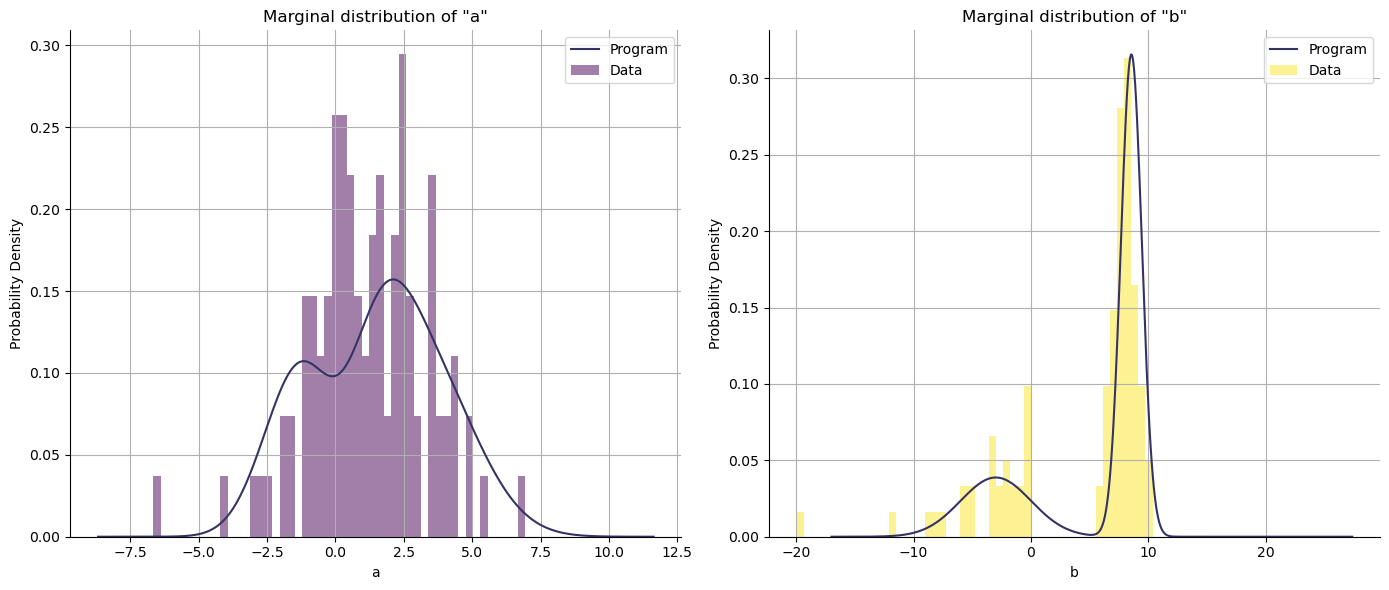

In [38]:
import matplotlib
#matplotlib.use('TkAgg') 

import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm


# Define the range for the uniform distribution
x = np.linspace(-10, 10, 500)
x = torch.tensor(x)

# Assuming data_var_list is defined
#data_var_list = ['a', 'b']  # Example list, replace with your actual list
colormap = cm.get_cmap('viridis', len(data_var_list))
colors = [colormap(i) for i in range(len(data_var_list))]


# Create a figure with subplots
fig, axs = plt.subplots(1, len(data_var_list), figsize=(14, 6))

# If there's only one element in data_var_list, axs will not be an array, so we need to handle that case
if len(data_var_list) == 1:
    axs = [axs]

# Loop through each element in data_var_list and create a subplot
for i, var in enumerate(data_var_list):
    color = colors[i]
    # select the x axis
    idx = output_dist.var_list.index(var)
    mean = output_dist.gm.mean()[idx]
    std = np.sqrt(output_dist.gm.cov()[idx, idx])
    x = np.linspace(mean-4*std, mean+4*std, 500)
    x = torch.tensor(x)
    # plots
    axs[i].plot(x, [get_mixture_pdf([xi], var, output_dist) for xi in x], label='Program', color='#333366')   
    axs[i].hist([pair[i] for pair in data], bins=50, density=True, alpha=0.5, color=color, label='Data')
    axs[i].set_title(f'Marginal distribution of "{var}"')
    axs[i].set_xlabel(f"{var}")
    axs[i].set_ylabel("Probability Density")
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['top'].set_visible(False)
    axs[i].grid(True)
    axs[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

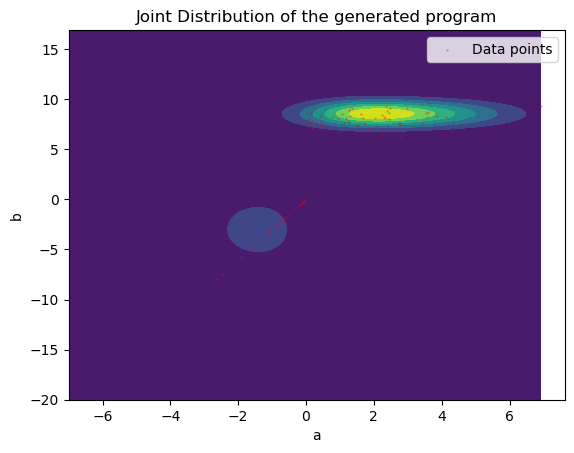

In [39]:
#3D image of the joint distribution
from mpl_toolkits.mplot3d import Axes3D

def get_mixture_pdf(point, data_var_list = data_var_list):
    pdf = 0
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= + output_dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)

    return pdf
        

vars_to_plot = ['a', 'b']
idx1 = output_dist.var_list.index(vars_to_plot[0])
mean1 = output_dist.gm.mean()[idx1]
std1= np.sqrt(output_dist.gm.cov()[idx1, idx1])
idx2 = output_dist.var_list.index(vars_to_plot[1])
mean2 = output_dist.gm.mean()[idx2]
std2= np.sqrt(output_dist.gm.cov()[idx2, idx2])
x1 = min(int(mean1-2*std1), int(np.min([data_point[data_var_list.index(vars_to_plot[0])] for data_point in data])))
x2 = max(int(mean1+2*std1), int(np.max([data_point[data_var_list.index(vars_to_plot[0])] for data_point in data])) )
y1 = min(int(mean2-2*std2), int(np.min([data_point[data_var_list.index(vars_to_plot[1])] for data_point in data])) )
y2 = max(int(mean2+2*std2), int(np.max([data_point[data_var_list.index(vars_to_plot[1])] for data_point in data])) )
x, y = np.mgrid[x1-1:x2+1:.1, y1-1:y2+1:.1]
pos = np.dstack((x, y))
#rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, get_mixture_pdf(pos, vars_to_plot), cmap='viridis')
ax2.scatter([pair[data_var_list.index(vars_to_plot[0])] for pair in data], [pair[data_var_list.index(vars_to_plot[1])] for pair in data], color = 'red', alpha = 0.7, s = 0.1, label = 'Data points')
ax2.set_title("Joint Distribution of the generated program")
ax2.set_xlabel(vars_to_plot[0])
ax2.set_ylabel(vars_to_plot[1])
ax2.legend()

In [40]:
#get the index of 'skill1' in the list data_var_list
idx1 = data_var_list.index('skill1')
idx1


ValueError: 'skill1' is not in list